<a href="https://colab.research.google.com/github/brooke57/BrainTumorImageClassification/blob/main/All_Models_for_Binary_Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Binary Brain Tumor Classification: All Models**

In [ ]:
# Set random state for numpy operations
from numpy.random import seed
seed(2)
# Set random state for tensorflow operations
from tensorflow.random import set_seed
set_seed(3)
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix
import cv2
import PIL

In [ ]:
# Defining a function that will freeze all layers in a pretrained and original network
# Code structure from https://github.com/learn-co-curriculum/dsc-using-pretrained-networks-codealong
def Freeze_Pretrained_Base(pretrain, model):
    
    '''This function will freeze all layers in a pretrained and original network
      pretrain: refers to any instantiated pretrained network
      model: the name of the model you are adding the pretrained network to
    '''
    pretrain.trainable = False
    for layer in model.layers:
        print(layer.name, layer.trainable)
    print(len(model.trainable_weights))

In [ ]:
# Re-freezing everything except for the last layer of the pretrained CNN
# Code structure from https://github.com/learn-co-curriculum/dsc-using-pretrained-networks-codealong
def Unfreeze_Layers(pretrain, layer_list):
    '''This function takes an instantiated pretrained neural network and a list containing layers to be frozen,
    and freezes those layers in the pretrained neural network.
    
    pretrain: refers to the instantiated pretrained neural network
    layer_list: refers to the list of layers to be frozen in the instantiated pretrained neural network.'''

    pretrain.trainable = True
    for layer in  pretrain.layers:
        if layer.name in layer_list:
            layer.trainable = True
        else:
            layer.trainable = False
        
    for layer in pretrain.layers:
        print(layer.name, layer.trainable)
    print(len(pretrain.trainable_weights))

In [ ]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [ ]:
def print_metrics(saved_model_name, generator, test_or_val):

  superior_model = load_model(saved_model_name)
  final_scores = superior_model.evaluate_generator(generator)
  metrics = ['Loss', 'Accuracy', 'Recall', 'Precision', 'True Positives', 'True Negatives', 'False Positives', 'False Negatives' ]
  
  for i, metric in enumerate(metrics):
    print(test_or_val+' '+ metric + ':', final_scores[i])

In [ ]:
# I modified this function slightly from the one found on: 
# https://github.com/austint1121/OES-PneumoniaClassification/blob/main/Final_Notebook.ipynb

def network_matrix(model_scores):
    """
    Plots a confusion matrix using the scores that come from evaluating a 
    neural network model using either testing or validation data
   
  
    Parameters:
    model_scores = load_model('model_name.h5').evaluate_generator(test/val_generator) 
  
    Returns:
    confusion matrix
    """
    tn = np.round((model_scores[5])/(model_scores[5] + model_scores[6]), 2)
    fn = np.round((model_scores[7])/(model_scores[7] + model_scores[4]), 2)
    fp = np.round((model_scores[6])/(model_scores[6] + model_scores[5]), 2)
    tp = np.round((model_scores[4])/(model_scores[4] + model_scores[7]), 2)
    
    
    conf = np.array([[tn, fp], [fn, tp]])
    fig, ax = plt.subplots(figsize=(10, 8))
    heat = sns.heatmap(conf, annot=True, fmt='g', ax=ax )
    heat.set_xticklabels(['Brain Tumor', 'Normal'], fontsize=15)
    heat.set_yticklabels(['Brain Tumor', 'Normal'], fontsize=15)
    plt.ylabel('Predicted Label',fontsize=18)
    plt.xlabel('True Label', fontsize=18)

In [ ]:
def print_metrics_confusionmatrix(saved_model_name, generator, test_or_val):

  superior_model = load_model(saved_model_name)
  final_scores = superior_model.evaluate_generator(generator)
  network_matrix(final_scores)
  metrics = ['Loss', 'Accuracy', 'Recall', 'Precision', 'True Positives', 'True Negatives', 'False Positives', 'False Negatives' ]
  
  for i, metric in enumerate(metrics):
    print(test_or_val+' '+ metric + ':', final_scores[i])

## **Data Retrieval and Loading**

First, I loaded data that I downloaded from kaggle onto my google drive account. Then I followed instructions from [this blog](https://towardsdatascience.com/an-informative-colab-guide-to-load-image-datasets-from-github-kaggle-and-local-machine-75cae89ffa1e) to load the data into this google colab notebook.

In [ ]:
# Retrieve the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import libraries
import zipfile
import os
# Load the data
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Brain_MRI_Tumor_Images.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') # Takes out files and puts them into the /tmp folder
zip_ref.close()

In [ ]:
# Specify the train and test file paths
base_direc = '/tmp/Brain_MRI_Tumor_Images'
train_direc = os.path.join(base_direc, 'Training')
test_direc = os.path.join(base_direc, 'Testing')

In [ ]:
# Code structure from https://github.com/austint1121/OES-PneumoniaClassification/blob/main/Final_Notebook.ipynb
# Set up ImageDataGenerator
train_imagegen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                   zoom_range=([0.6,1]),
                                   rotation_range=10,                           
                                   brightness_range=([0.6, 1.5]),
                                   horizontal_flip=True,
                                   validation_split=0.06) # this will set aside a part of training set for validation data
test_imagegen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                   zoom_range=([0.6,1]),
                                   rotation_range=10,
                                   brightness_range=([0.6,1.5]),
                                   horizontal_flip=True)
# Bring the data in
train_generator = train_imagegen.flow_from_directory(
                                    train_direc,
                                    classes={'no_tumor_train':0,
                                            'AllTumorsTrain':1},
                                    target_size=(200,200),
                                    batch_size=20,
                                    seed=42,
                                    class_mode='binary',
                                    subset='training')

test_generator = test_imagegen.flow_from_directory(
                                    test_direc,
                                     classes={'no_tumor_test':0,
                                            'AllTumorsTest':1},
                                    target_size=(200,200),
                                    batch_size=20,
                                    seed=42,
                                    class_mode='binary')

val_generator = train_imagegen.flow_from_directory(
                                    train_direc,
                                     classes={'no_tumor_train':0,
                                            'AllTumorsTrain':1},
                                    target_size=(200,200),
                                    batch_size=20,
                                    seed=42,
                                    class_mode='binary',
                                    subset='validation')

Found 2699 images belonging to 2 classes.
Found 394 images belonging to 2 classes.
Found 171 images belonging to 2 classes.


## **Baseline CNN Model**

In [ ]:
# Building the first baseline model; structure is modified from one shown on:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
baseline = keras.Sequential()
baseline.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
baseline.add(layers.MaxPooling2D(2,2))
baseline.add(layers.Conv2D(64, (3,3), activation='relu'))
baseline.add(layers.MaxPooling2D(2,2))

baseline.add(layers.Flatten())
baseline.add(layers.Dense(128, activation='relu'))
baseline.add(layers.Dense(1, activation='sigmoid'))

baseline.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

In [ ]:
# Info for how to construct steps_per_epoch value from:
# https://stackoverflow.com/questions/46010565/checking-validation-results-in-keras-shows-only-50-correct-clearly-random
baseline_results = baseline.fit_generator(train_generator,
                                         steps_per_epoch=2699 // 20 +1,# number of samples / batch size plus one, so that every batch is included
                                         epochs=10,
                                        validation_data=test_generator,
                                         validation_steps= 394 // 20+1)

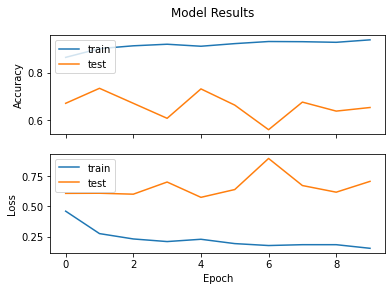

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(baseline_results)

**Analysis of Model**

In the last epoch, the training accuracy is 93% and testing accuracy is 58%, with a training loss of 17% and a testing loss of 76%. Testing recall is 50% and testing precision is 86%. Obviously, the model is overfitting, and loss is quite high; the recall score is very low as well. In the next model iteration, I will add another dense layer, which will hopefully help the model pick up on more patterns, and some dropout layers for a form of regularization.

## **Adding another Dense layer and Dropout layers**

In [ ]:
# Adding another dense layer and a couple of dropout layers; structure is modified from one shown on:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
layers_drop = keras.Sequential()
layers_drop.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
layers_drop.add(layers.MaxPooling2D(2,2))
layers_drop.add(layers.Conv2D(64, (3,3), activation='relu'))
layers_drop.add(layers.MaxPooling2D(2,2))

layers_drop.add(layers.Flatten())
layers_drop.add(layers.Dense(128, activation='relu'))
layers_drop.add(layers.Dropout(0.3))
layers_drop.add(layers.Dense(64, activation='relu'))
layers_drop.add(layers.Dropout(0.3))
layers_drop.add(layers.Dense(1, activation='sigmoid'))

layers_drop.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

In [ ]:
# Fitting the model
layers_drop_results = layers_drop.fit_generator(train_generator,
                                         steps_per_epoch=2699 // 20+1,# number of samples / batch size
                                         epochs=10,
                                         validation_data=test_generator,
                                        validation_steps= 394 // 20+1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
135/135 [==============================] - 40s 284ms/step - loss: 0.4637 - acc: 0.8581 - recall: 0.9914 - precision: 0.8640 - true_positives: 2307.0000 - true_negatives: 9.0000 - false_positives: 363.0000 - false_negatives: 20.0000 - val_loss: 0.6027 - val_acc: 0.7335 - val_recall: 1.0000 - val_precision: 0.7335 - val_true_positives: 289.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 105.0000 - val_false_negatives: 0.0000e+00
Epoch 2/10
135/135 [==============================] - 37s 278ms/step - loss: 0.3379 - acc: 0.8725 - recall: 0.9944 - precision: 0.8749 - true_positives: 2314.0000 - true_negatives: 41.0000 - false_positives: 331.0000 - false_negatives: 13.0000 - val_loss: 0.5985 - val_acc: 0.7132 - val_recall: 0.7924 - val_precision: 0.8121 - val_true_positives: 229.0000 - val_true_negatives: 52.0000 - val_false_positives: 53.0000 - val_false_negatives: 60.0000
Epoch 3/10
135/135 [==============================] - 37s 278ms/step - loss: 0.2935 - acc: 0.898

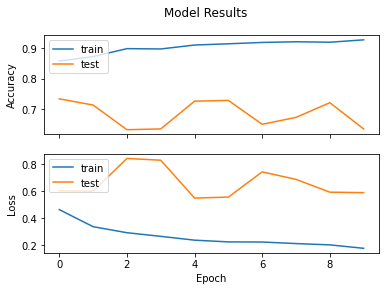

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(layers_drop_results)

**Analysis of Model**

In this iteration, training accuracy ends up at 92%, and testing ends up at 70%, so the model is still overfitting. As for loss, training loss is 21% and testing loss is 57%, which is not drastically different from the last model. Testing recall is 65% and testing precision is 91%. In the next model iteration I am going to try including another Convolution Layer, to see if this will help the model pick up on more patterns.

## **Accounting for Class Imbalance**

In [ ]:
# Accounting for class imbalance; structure is modified from one shown on:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

class_ld = keras.Sequential()
class_ld.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
class_ld.add(layers.MaxPooling2D(2,2))
class_ld.add(layers.Conv2D(64, (3,3), activation='relu'))
class_ld.add(layers.MaxPooling2D(2,2))

class_ld.add(layers.Flatten())
class_ld.add(layers.Dense(128, activation='relu'))
class_ld.add(layers.Dropout(0.3))
class_ld.add(layers.Dense(64, activation='relu'))
class_ld.add(layers.Dropout(0.3))
class_ld.add(layers.Dense(1, activation='sigmoid'))

class_ld.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
weights = {0: 6.255, # NO TUMOR
          1: 1.} #  TUMOR 
# there are 6.255 times as many images of MRIs with tumors than without

In [ ]:
# Fitting the model
class_ld_results = class_ld.fit_generator(train_generator,
                                          class_weight=weights,
                                         steps_per_epoch=2699//20+1,# number of samples / batch size
                                         epochs=10,
                                         validation_data=test_generator,
                                         validation_steps=394//20+1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
135/135 [==============================] - 39s 280ms/step - loss: 1.2178 - acc: 0.6047 - recall: 0.6012 - precision: 0.9096 - true_positives: 1399.0000 - true_negatives: 233.0000 - false_positives: 139.0000 - false_negatives: 928.0000 - val_loss: 1.0693 - val_acc: 0.2970 - val_recall: 0.0623 - val_precision: 0.7500 - val_true_positives: 18.0000 - val_true_negatives: 99.0000 - val_false_positives: 6.0000 - val_false_negatives: 271.0000
Epoch 2/10
135/135 [==============================] - 36s 270ms/step - loss: 0.9013 - acc: 0.7336 - recall: 0.7331 - precision: 0.9457 - true_positives: 1706.0000 - true_negatives: 274.0000 - false_positives: 98.0000 - false_negatives: 621.0000 - val_loss: 0.9376 - val_acc: 0.4898 - val_recall: 0.3599 - val_precision: 0.8667 - val_true_positives: 104.0000 - val_true_negatives: 89.0000 - val_false_positives: 16.0000 - val_false_negatives: 185.0000
Epoch 3/10
135/135 [==============================] - 37s 272ms/step - loss: 0.8287 - acc: 0.7870 -

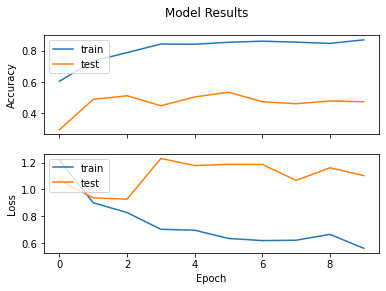

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(class_ld_results)

**Analysis of Model**

In this model iteration, training accuracy was about 87% and testing accuracy is about 49%, so the model is still overfitting, more so than in the last model. Loss for training is at around 58% and testing loss is around 133%. Testing recall is 32% and testing precision is 95%; it is clear that accounting for class imbalance in this way has made the model worse. Further research lead me to a [great article](https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/), which discusses how class weights should be calculated. It mentions how adding too much weight to the minority class can sometimes cause the model to show a bias towards it, getting more images in the majority class wrong and making the model less robust. The calculation for what weight to put on the minority class is: total # samples / (2 * number of samples in the minority class). This calculation applied to the training data samples is as follows: 2870/(2*395), which comes out to be about 3.63. So, the class weight for the minority class, in this case "no_tumor" MRIs, should be close to 3.63. In the next model, I will see if a class weight of three applied to the no tumor images will be beneficial.

## **Adjusting Class Weights of Previous Model**

In [ ]:
# Accounting for class imbalance; structure is modified from one shown on:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

adjclass_ld = keras.Sequential()
adjclass_ld.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
adjclass_ld.add(layers.MaxPooling2D(2,2))
adjclass_ld.add(layers.Conv2D(64, (3,3), activation='relu'))
adjclass_ld.add(layers.MaxPooling2D(2,2))

adjclass_ld.add(layers.Flatten())
adjclass_ld.add(layers.Dense(128, activation='relu'))
adjclass_ld.add(layers.Dropout(0.3))
adjclass_ld.add(layers.Dense(64, activation='relu'))
adjclass_ld.add(layers.Dropout(0.3))
adjclass_ld.add(layers.Dense(1, activation='sigmoid'))

adjclass_ld.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
# Incorporating adjusted class weights; compiling and fitting the model
weights3 = {0: 3, # NO TUMOR
          1:1.} # TUMOR 
# there are 6.255 times as many images of MRIs with tumors than without, but acording to the class weight calculation, I should 
# use a number close to 3.63 for the minority class, in this case the no tumor, or "zero" class.

In [ ]:
# Fitting the model
adjclass_ld_results = adjclass_ld.fit_generator(train_generator,
                                          class_weight=weights3,
                                         steps_per_epoch=2699//20+1,# number of samples / batch size
                                         epochs=10,
                                         validation_data=test_generator,
                                         validation_steps=394//20+1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
135/135 [==============================] - 47s 274ms/step - loss: 0.8778 - acc: 0.8355 - recall: 0.9648 - precision: 0.8611 - true_positives: 2245.0000 - true_negatives: 10.0000 - false_positives: 362.0000 - false_negatives: 82.0000 - val_loss: 0.6481 - val_acc: 0.7335 - val_recall: 1.0000 - val_precision: 0.7335 - val_true_positives: 289.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 105.0000 - val_false_negatives: 0.0000e+00
Epoch 2/10
135/135 [==============================] - 37s 272ms/step - loss: 0.6783 - acc: 0.8492 - recall: 0.9368 - precision: 0.8934 - true_positives: 2180.0000 - true_negatives: 112.0000 - false_positives: 260.0000 - false_negatives: 147.0000 - val_loss: 0.6651 - val_acc: 0.6447 - val_recall: 0.6332 - val_precision: 0.8433 - val_true_positives: 183.0000 - val_true_negatives: 71.0000 - val_false_positives: 34.0000 - val_false_negatives: 106.0000
Epoch 3/10
135/135 [==============================] - 37s 272ms/step - loss: 0.5734 - acc: 0

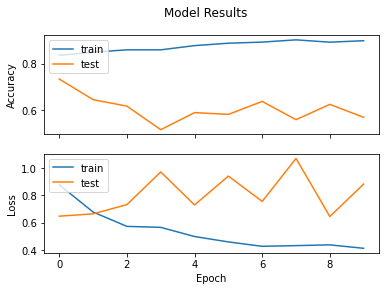

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(adjclass_ld_results)

**Analysis of model**

Training accuracy is 91% and testing accuracy is 60%, with a training loss of 35% and a testing loss of 80%. Testing recall is 49% and testing precision is 93%. Although this model still requires much fine tuning, it is clear that adjusting the class weights made it perform a bit better, so these weights will be used from now on. In the next iteration, I will try incorporating class weights.

## **Adding another Convolution Layer**

In [ ]:
# Another Convolution layer; structure is modified from one shown on:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
class_con = keras.Sequential()
class_con.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
class_con.add(layers.MaxPooling2D(2,2))
class_con.add(layers.Conv2D(64, (3,3), activation='relu'))
class_con.add(layers.MaxPooling2D(2,2))
class_con.add(layers.Conv2D(128, (3,3), activation='relu'))
class_con.add(layers.MaxPooling2D(2,2))

class_con.add(layers.Flatten())
class_con.add(layers.Dense(128, activation='relu'))
class_con.add(layers.Dropout(0.3))
class_con.add(layers.Dense(64, activation='relu'))
class_con.add(layers.Dropout(0.3))
class_con.add(layers.Dense(1, activation='sigmoid'))

class_con.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
weights3 = {0: 3, # NO TUMOR
          1: 1.} # TUMOR

In [ ]:
# Fitting the model
class_con_results = class_con.fit_generator(train_generator,
                                          class_weight=weights3,
                                         steps_per_epoch=2699//20+1,# number of samples / batch size
                                         epochs=10,
                                         validation_data=test_generator,
                                         validation_steps=394//20+1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
135/135 [==============================] - 46s 271ms/step - loss: 0.7695 - acc: 0.8477 - recall: 0.9648 - precision: 0.8722 - true_positives: 2245.0000 - true_negatives: 43.0000 - false_positives: 329.0000 - false_negatives: 82.0000 - val_loss: 0.6625 - val_acc: 0.5863 - val_recall: 0.5744 - val_precision: 0.8058 - val_true_positives: 166.0000 - val_true_negatives: 65.0000 - val_false_positives: 40.0000 - val_false_negatives: 123.0000
Epoch 2/10
135/135 [==============================] - 36s 269ms/step - loss: 0.6209 - acc: 0.8562 - recall: 0.9050 - precision: 0.9265 - true_positives: 2106.0000 - true_negatives: 205.0000 - false_positives: 167.0000 - false_negatives: 221.0000 - val_loss: 0.6544 - val_acc: 0.6523 - val_recall: 0.7163 - val_precision: 0.7901 - val_true_positives: 207.0000 - val_true_negatives: 50.0000 - val_false_positives: 55.0000 - val_false_negatives: 82.0000
Epoch 3/10
135/135 [==============================] - 36s 270ms/step - loss: 0.5075 - acc: 0.8674 -

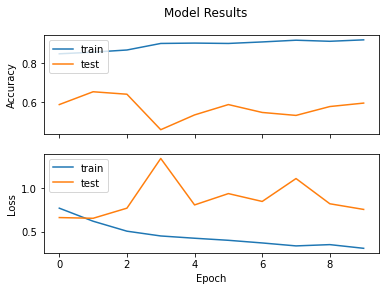

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(class_con_results)

**Analysis of Model**

The last epoch had a training accuracy of 92% and a testing accuracy of 59%, with a training loss of 33% and a testing loss of 83%. Testing recall is 51% and testing precision is 89%. Adding another convolution layer did not seem to improve the network results; next I will adjust the pooling strategy, to see if this improves the model. 

## **Adjusting the Pooling Strategy**

In [ ]:
# Another Convolution layer; structure is modified from one shown on:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
class_pool = keras.Sequential()
class_pool.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
class_pool.add(layers.MaxPooling2D(2,2))
class_pool.add(layers.Conv2D(64, (3,3), activation='relu'))
class_pool.add(layers.MaxPooling2D(3,3))
class_pool.add(layers.Conv2D(128, (3,3), activation='relu'))
class_pool.add(layers.MaxPooling2D(5,5))

class_pool.add(layers.Flatten())
class_pool.add(layers.Dense(128, activation='relu'))
class_pool.add(layers.Dropout(0.3))
class_pool.add(layers.Dense(64, activation='relu'))
class_pool.add(layers.Dropout(0.3))
class_pool.add(layers.Dense(1, activation='sigmoid'))

class_pool.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
weights3 = {0: 3, # NO TUMOR
          1: 1.} # TUMOR
# there are 6.255 times as many images of MRIs with tumors than without

In [ ]:
# Fitting the model
class_pool_results = class_pool.fit_generator(train_generator,
                                          class_weight=weights3,
                                         steps_per_epoch=2699//20+1 ,# number of samples / batch size
                                         epochs=10,
                                         validation_data=test_generator,
                                         validation_steps=394//20+1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
135/135 [==============================] - 39s 277ms/step - loss: 0.7635 - acc: 0.8503 - recall: 0.9635 - precision: 0.8754 - true_positives: 2242.0000 - true_negatives: 53.0000 - false_positives: 319.0000 - false_negatives: 85.0000 - val_loss: 0.7051 - val_acc: 0.5178 - val_recall: 0.4706 - val_precision: 0.7861 - val_true_positives: 136.0000 - val_true_negatives: 68.0000 - val_false_positives: 37.0000 - val_false_negatives: 153.0000
Epoch 2/10
135/135 [==============================] - 36s 268ms/step - loss: 0.5703 - acc: 0.8581 - recall: 0.9007 - precision: 0.9324 - true_positives: 2096.0000 - true_negatives: 220.0000 - false_positives: 152.0000 - false_negatives: 231.0000 - val_loss: 0.8085 - val_acc: 0.5381 - val_recall: 0.4394 - val_precision: 0.8639 - val_true_positives: 127.0000 - val_true_negatives: 85.0000 - val_false_positives: 20.0000 - val_false_negatives: 162.0000
Epoch 3/10
135/135 [==============================] - 36s 269ms/step - loss: 0.5470 - acc: 0.8607 

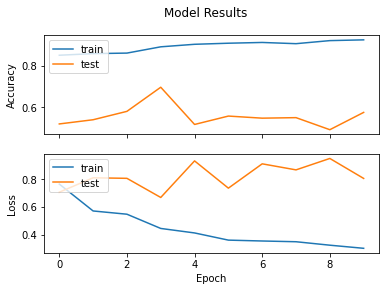

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(class_pool_results)

**Analysis of Model**

The last epoch has a training accuracy of 93% and a testing accuracy of 48%, with a training loss of 29% and a testing loss of 107%. Testing recall is 31% and testing precision is 95%. Testing accuracy and loss has increased since the last model, so it seems that the original pooling strategy is best. In the next iteration, I will introduce padding to see if this helps make the network more accuarte.

## **Model with Padding**

In [ ]:
# Another Convolution layer; structure is modified from one shown on:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
np.random.seed(42)
class_pad = keras.Sequential()
class_pad.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(200,200,3)))
class_pad.add(layers.MaxPooling2D(2,2))
class_pad.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
class_pad.add(layers.MaxPooling2D(2,2))
class_pad.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
class_pad.add(layers.MaxPooling2D(2,2))

class_pad.add(layers.Flatten())
class_pad.add(layers.Dense(128, activation='relu'))
class_pad.add(layers.Dropout(0.3))
class_pad.add(layers.Dense(64, activation='relu'))
class_pad.add(layers.Dropout(0.3))
class_pad.add(layers.Dense(1, activation='sigmoid'))

class_pad.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
weights3 = {0: 3, # NO TUMOR
          1: 1.} # TUMOR
# there are 6.255 times as many images of MRIs with tumors than without

In [ ]:
# Setting up early stopping and model checkpoints so that model stops training after testing loss stops improving and so that
# weights from the epoch with the lowest testing loss are saved
# Information on how to set up early stopping from: 
# https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb
early_stop = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss',
                           save_best_only=True)]

In [ ]:
class_pad_results = class_pad.fit_generator(train_generator,
                                          class_weight=weights3,
                                         steps_per_epoch=2699//20+1,# number of samples / batch size
                                         epochs=10,
                                         validation_data=test_generator,
                                         validation_steps=394//20+1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
135/135 [==============================] - 48s 285ms/step - loss: 0.8265 - acc: 0.8611 - recall: 0.9957 - precision: 0.8639 - true_positives: 2317.0000 - true_negatives: 7.0000 - false_positives: 365.0000 - false_negatives: 10.0000 - val_loss: 0.6717 - val_acc: 0.7005 - val_recall: 0.9481 - val_precision: 0.7268 - val_true_positives: 274.0000 - val_true_negatives: 2.0000 - val_false_positives: 103.0000 - val_false_negatives: 15.0000
Epoch 2/10
135/135 [==============================] - 37s 277ms/step - loss: 0.6847 - acc: 0.8355 - recall: 0.9085 - precision: 0.9015 - true_positives: 2114.0000 - true_negatives: 141.0000 - false_positives: 231.0000 - false_negatives: 213.0000 - val_loss: 0.6757 - val_acc: 0.6345 - val_recall: 0.6228 - val_precision: 0.8372 - val_true_positives: 180.0000 - val_true_negatives: 70.0000 - val_false_positives: 35.0000 - val_false_negatives: 109.0000
Epoch 3/10
135/135 [==============================] - 37s 275ms/step - loss: 0.5507 - acc: 0.8677 - 

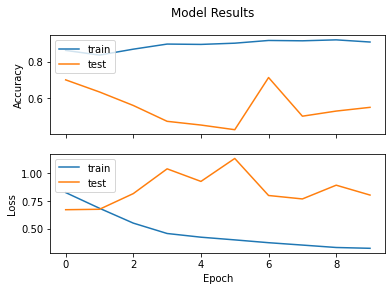

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(class_pad_results)

**Analysis of Model**

The last epoch has a training accuracy of 93% and a testing accuracy of 61%, with a training loss of 30% and a testing loss of 71%. Testing recall is 56%, testing precision is 98%. Testing accuracy and loss are better than in the last model iteration, but the results still aren't great. In the next iteration, I will remove the padding and I try introducing Batch Normalization, as this standardizes the input to each layer, and has the potential to decrease the potential to decrease the number of required training epochs to get optimal weights, according to [this article](https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/#:~:text=Batch%20normalization%20is%20a%20technique,required%20to%20train%20deep%20networks.).

## **Model with Batch Normalization**

In [ ]:
# Adding Batch Normalization; structure is modified from one shown on:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
class_n = keras.Sequential()
class_n.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
class_n.add(layers.BatchNormalization())
class_n.add(layers.MaxPooling2D(2,2))
class_n.add(layers.Conv2D(64, (3,3), activation='relu'))
class_n.add(layers.BatchNormalization())
class_n.add(layers.MaxPooling2D(2,2))
class_n.add(layers.Conv2D(128, (3,3), activation='relu'))
class_n.add(layers.BatchNormalization())
class_n.add(layers.MaxPooling2D(2,2))

class_n.add(layers.Flatten())
class_n.add(layers.Dense(128, activation='relu'))
class_n.add(layers.Dropout(0.3))
class_n.add(layers.Dense(1, activation='sigmoid'))

class_n.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
# Incorporating adjusted class weights; compiling and fitting the model
weights3 = {0: 3, # NO TUMOR
          1:1.} # TUMOR 
# there are 6.255 times as many images of MRIs with tumors than without, but acording to the class weight calculation, I should 
# use a number close to 3.63 for the minority class, in this case the no tumor, or "zero" class.

In [ ]:
# Setting up early stopping and model checkpoints so that model stops training after testing loss stops improving and so that
# weights from the epoch with the lowest testing loss are saved
# Information on how to set up early stopping from: 
# https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb
early_stop_bn1 = [EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
            ModelCheckpoint(filepath='bn_best_model.h5', monitor='val_loss',
                           save_best_only=True)]

In [ ]:
class_n_results = class_n.fit_generator(train_generator,
                                          class_weight=weights3,
                                         steps_per_epoch=2699//20+1,# number of samples / batch size
                                         epochs=20,
                                         callbacks=early_stop_bn1,
                                         validation_data=test_generator,
                                         validation_steps=394//20+1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
135/135 [==============================] - 40s 284ms/step - loss: 4.6016 - acc: 0.7810 - recall: 0.8272 - precision: 0.9106 - true_positives: 1925.0000 - true_negatives: 183.0000 - false_positives: 189.0000 - false_negatives: 402.0000 - val_loss: 1.3812 - val_acc: 0.6269 - val_recall: 0.6125 - val_precision: 0.8349 - val_true_positives: 177.0000 - val_true_negatives: 70.0000 - val_false_positives: 35.0000 - val_false_negatives: 112.0000
Epoch 2/20
135/135 [==============================] - 38s 278ms/step - loss: 1.0584 - acc: 0.8392 - recall: 0.9123 - precision: 0.9023 - true_positives: 2123.0000 - true_negatives: 142.0000 - false_positives: 230.0000 - false_negatives: 204.0000 - val_loss: 0.7076 - val_acc: 0.7259 - val_recall: 0.9792 - val_precision: 0.7351 - val_true_positives: 283.0000 - val_true_negatives: 3.0000 - val_false_positives: 102.0000 - val_false_negatives: 6.0000
Epoch 3/20
135/135 [==============================] - 37s 274ms/step - loss: 0.6638 - acc: 0.8455 

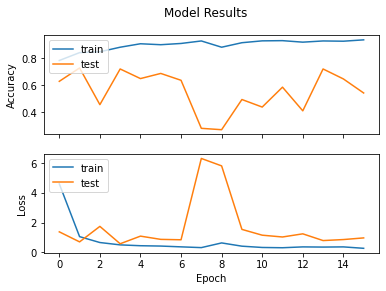

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(class_n_results)

**Analysis of Model**

 In the epoch with the lowest testing loss, training accuracy is 91% and testing accuracy is 66%, with a training loss of 30% and a testing loss of 56%. Testing recall is 57% and testing precision is 96%. Loss has been decreased in this model iteration compared to the last.
 
 Because batch normalization makes the network more stable, it is possible to use larger learning rates, which could potentially help the model reach optimal accuracy and minimal loss more quickly, so that is what I will try next.

## **Using a Bigger Learning Rate since I am using Batch Normalization**

In [ ]:
# Establishing an instance of Adam with a bigger learning rate
adam_mlr = keras.optimizers.Adam(epsilon=0.01)

In [ ]:
# Using Batch Normalization; structure is modified from one shown on:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
class_na = keras.Sequential()
class_na.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
class_na.add(layers.BatchNormalization())
class_na.add(layers.MaxPooling2D(2,2))
class_na.add(layers.Conv2D(64, (3,3), activation='relu'))
class_na.add(layers.BatchNormalization())
class_na.add(layers.MaxPooling2D(2,2))
class_na.add(layers.Conv2D(128, (3,3), activation='relu'))
class_na.add(layers.BatchNormalization())
class_na.add(layers.MaxPooling2D(2,2))

class_na.add(layers.Flatten())
class_na.add(layers.Dense(128, activation='relu'))
class_na.add(layers.Dropout(0.3))
class_na.add(layers.Dense(1, activation='sigmoid'))

class_na.compile(loss='binary_crossentropy',
                optimizer=adam_mlr,
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
# Incorporating adjusted class weights; compiling and fitting the model
weights3 = {0: 3, # NO TUMOR
          1:1.} # TUMOR 
# there are 6.255 times as many images of MRIs with tumors than without, but acording to the class weight calculation, I should 
# use a number close to 3.63 for the minority class, in this case the no tumor, or "zero" class.

In [ ]:
# Setting up early stopping and model checkpoints so that model stops training after testing loss stops improving and so that
# weights from the epoch with the lowest testing loss are saved
# Information on how to set up early stopping from: 
# https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb
early_stop_bl1 = [EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
            ModelCheckpoint(filepath='bl_best_model.h5', monitor='val_loss',
                           save_best_only=True)]

In [ ]:
# Using a bigger learning rate; fitting the model
class_na_results = class_na.fit_generator(train_generator,
                                          class_weight=weights3,
                                         steps_per_epoch=2699//20+1,# number of samples / batch size
                                         epochs=20,
                                         callbacks=early_stop_bl1,
                                         validation_data=test_generator,
                                         validation_steps=394//20+1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
135/135 [==============================] - 48s 283ms/step - loss: 1.1049 - acc: 0.7973 - recall: 0.8367 - precision: 0.9210 - true_positives: 1947.0000 - true_negatives: 205.0000 - false_positives: 167.0000 - false_negatives: 380.0000 - val_loss: 2.8481 - val_acc: 0.7335 - val_recall: 1.0000 - val_precision: 0.7335 - val_true_positives: 289.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 105.0000 - val_false_negatives: 0.0000e+00
Epoch 2/20
135/135 [==============================] - 38s 280ms/step - loss: 0.5029 - acc: 0.8759 - recall: 0.9067 - precision: 0.9470 - true_positives: 2110.0000 - true_negatives: 254.0000 - false_positives: 118.0000 - false_negatives: 217.0000 - val_loss: 0.9632 - val_acc: 0.7386 - val_recall: 0.9931 - val_precision: 0.7397 - val_true_positives: 287.0000 - val_true_negatives: 4.0000 - val_false_positives: 101.0000 - val_false_negatives: 2.0000
Epoch 3/20
135/135 [==============================] - 38s 280ms/step - loss: 0.4827 - acc: 0

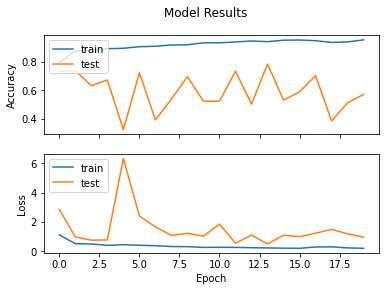

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(class_na_results)

**Analysis of Model**

In the epoch with the lowest testing loss, training accuracy is 91% while testing accuracy is 75%. Training loss is 27%, while testing loss is 43%. 
Testing recall is 89% and testing precision is 90%. Testing accuracy is a little greater and testing loss is a bit lower than in the last iteration, so it looks like using a bigger learning rate in combination with Batch Normalization was a good idea. 

## **Model with Batch Normalization and more Dropout Layers**

In [ ]:
# Using Batch normalization with more layers; structure is modified from one shown on:
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
class_nd = keras.Sequential()

class_nd.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
class_nd.add(layers.BatchNormalization())
class_nd.add(layers.MaxPooling2D(2,2))
class_nd.add(layers.Dropout(0.25))

class_nd.add(layers.Conv2D(64, (3,3), activation='relu'))
class_nd.add(layers.BatchNormalization())
class_nd.add(layers.MaxPooling2D(2,2))
class_nd.add(layers.Dropout(0.25))

class_nd.add(layers.Conv2D(128, (3,3), activation='relu'))
class_nd.add(layers.BatchNormalization())
class_nd.add(layers.MaxPooling2D(2,2))
class_nd.add(layers.Dropout(0.25))

class_nd.add(layers.Flatten())
class_nd.add(layers.Dense(128, activation='relu'))
class_nd.add(layers.Dropout(0.4))
class_nd.add(layers.Dense(1, activation='sigmoid'))

class_nd.compile(loss='binary_crossentropy',
                optimizer= adam_mlr,
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
# Incorporating adjusted class weights; compiling and fitting the model
weights3 = {0: 3, # NO TUMOR
          1:1.} # TUMOR 
# there are 6.255 times as many images of MRIs with tumors than without, but acording to the class weight calculation, I should 
# use a number close to 3.63 for the minority class, in this case the no tumor, or "zero" class.

In [ ]:
# Setting up early stopping and model checkpoints so that model stops training after testing loss stops improving and so that
# weights from the epoch with the lowest testing loss are saved
# Information on how to set up early stopping from: 
# https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb
early_stop_bnd = [EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
            ModelCheckpoint(filepath='bnd_best_model.h5', monitor='val_loss',
                           save_best_only=True)]

In [ ]:
# Fitting the model
class_nd_results = class_nd.fit_generator(train_generator,
                                          class_weight=weights3,
                                         steps_per_epoch=2699//20+1,# number of samples / batch size
                                         epochs=20,
                                          callbacks=early_stop_bnd,
                                         validation_data=test_generator,
                                         validation_steps=394//20+1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
135/135 [==============================] - 47s 280ms/step - loss: 1.0969 - acc: 0.7799 - recall: 0.8311 - precision: 0.9059 - true_positives: 1934.0000 - true_negatives: 171.0000 - false_positives: 201.0000 - false_negatives: 393.0000 - val_loss: 4.0970 - val_acc: 0.7335 - val_recall: 1.0000 - val_precision: 0.7335 - val_true_positives: 289.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 105.0000 - val_false_negatives: 0.0000e+00
Epoch 2/20
135/135 [==============================] - 37s 276ms/step - loss: 0.6554 - acc: 0.8233 - recall: 0.8698 - precision: 0.9208 - true_positives: 2024.0000 - true_negatives: 198.0000 - false_positives: 174.0000 - false_negatives: 303.0000 - val_loss: 0.9029 - val_acc: 0.3350 - val_recall: 0.2318 - val_precision: 0.6262 - val_true_positives: 67.0000 - val_true_negatives: 65.0000 - val_false_positives: 40.0000 - val_false_negatives: 222.0000
Epoch 3/20
135/135 [==============================] - 37s 277ms/step - loss: 0.5386 - acc: 

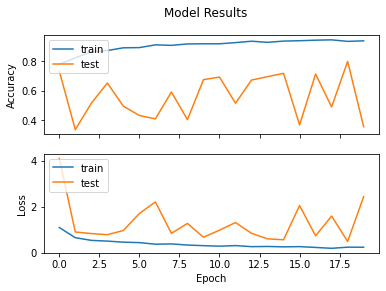

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(class_nd_results)

**Analysis of Model**

Training accuracy of the epoch with the lowest loss is 86% while testing accuracy is 74%. Training loss is 41% while testing loss is 68%. Testing recall is 100% and testing precision is 74%. Training and Testing loss have both increased, so the dropout layers added after each max pooling step may not be particularly beneficial to the model. Next, I will try using pretrained neural networks.

## **Using the Pre-Trained VGG-19 Weights (this is my FSM)**

In [ ]:
# Instantiating the pretrained VGG-19 model
from keras.applications.vgg19 import VGG19
cnn_vgg = VGG19(weights='imagenet',
               include_top=False,
               input_shape=(200,200,3))

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
# Build first model using pretrained VGG 19 as first layer, and then some dense layers on top
pretrained = keras.Sequential()
pretrained.add(cnn_vgg)
pretrained.add(layers.Flatten())
pretrained.add(layers.Dense(128, activation='relu'))
pretrained.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
Freeze_Pretrained_Base(cnn_vgg, pretrained)

vgg19 False
flatten True
dense True
dense_1 True
4


In [ ]:
# Setting up early stopping and model checkpoints so that model stops training after testing loss stops improving and so that
# weights from the epoch with the lowest testing loss are saved
# Information on how to set up early stopping from: 
# https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb
early_stop_pre1 = [EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
            ModelCheckpoint(filepath='pre1_best_model.h5', monitor='val_loss',
                           save_best_only=True)]

In [ ]:
pretrained.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

pretrained_results = pretrained.fit_generator(train_generator,
                                         steps_per_epoch=2699//20+1,# number of samples / batch size
                                         epochs=20,
                                        callbacks= early_stop_pre1,
                                         validation_data=test_generator,
                                             validation_steps=394//20+1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
135/135 [==============================] - 54s 320ms/step - loss: 0.2674 - acc: 0.9133 - recall: 0.9622 - precision: 0.9388 - true_positives: 2239.0000 - true_negatives: 226.0000 - false_positives: 146.0000 - false_negatives: 88.0000 - val_loss: 0.8840 - val_acc: 0.7741 - val_recall: 0.9896 - val_precision: 0.7688 - val_true_positives: 286.0000 - val_true_negatives: 19.0000 - val_false_positives: 86.0000 - val_false_negatives: 3.0000
Epoch 2/20
135/135 [==============================] - 40s 298ms/step - loss: 0.1599 - acc: 0.9466 - recall: 0.9785 - precision: 0.9604 - true_positives: 2277.0000 - true_negatives: 278.0000 - false_positives: 94.0000 - false_negatives: 50.0000 - val_loss: 0.4379 - val_acc: 0.8376 - val_recall: 0.8893 - val_precision: 0.8893 - val_true_positives: 257.0000 - val_true_negatives: 73.0000 - val_false_positives: 32.0000 - val_false_negatives: 32.0000
Epoch 3/20
135/135 [==============================] - 40s 299ms/step - loss: 0.1565 - acc: 0.9411 - re

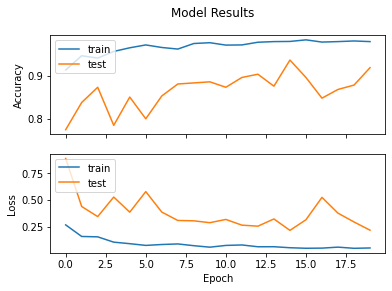

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(pretrained_results)

**Analysis of Model**

The epoch with the lowest testing loss has a training accuracy of 95% and a testing accuracy of 82%, with a training loss of 14% and a testing loss of 45%. Testing recall is 87%, and testing precision is 88%. Testing loss is lower and testing accuracy is higher than in the previous model, so using pretrianed models looks promising. In the next iteration, I will try fine tuning this network by adding dropout layers and unfreezing some of the outer layers of the pretrained network so they can learn from the images in this dataset.

## **Adding Dropout Layers and unfreezing outer layers**

In [ ]:
# Build first model using pretrained VGG 19 as first layer, and then some dense layers on top
b5c3c4_drop = keras.Sequential()
b5c3c4_drop.add(cnn_vgg)
b5c3c4_drop.add(layers.Dropout(0.4))
b5c3c4_drop.add(layers.Flatten())
b5c3c4_drop.add(layers.Dense(128, activation='relu'))
b5c3c4_drop.add(layers.Dropout(0.4))
b5c3c4_drop.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
Freeze_Pretrained_Base(cnn_vgg, b5c3c4_drop)

vgg19 False
dropout_12 True
flatten_4 True
dense_8 True
dropout_13 True
dense_9 True
4


In [ ]:
cnn_vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
unfreeze2 = ['block5_conv3','block5_conv4']

In [ ]:
Unfreeze_Layers(cnn_vgg, unfreeze2)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_conv4 True
block5_pool False
4


In [ ]:
# Setting up early stopping and model checkpoints so that model stops training after testing loss stops improving and so that
# weights from the epoch with the lowest testing loss are saved
# Information on how to set up early stopping from: 
# https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb
early_stop_pre2 = [EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
            ModelCheckpoint(filepath='pre2_best_model.h5', monitor='val_loss',
                           save_best_only=True)]

In [ ]:
b5c3c4_drop.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

b5c3c4_drop_results = b5c3c4_drop.fit_generator(train_generator,
                                         steps_per_epoch=2699//20+1,# number of samples / batch size
                                         epochs=20,
                                        callbacks= early_stop_pre2,
                                         validation_data=test_generator,
                                             validation_steps=394//20+1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
135/135 [==============================] - 43s 303ms/step - loss: 0.3405 - acc: 0.8829 - recall: 0.9746 - precision: 0.8982 - true_positives: 2268.0000 - true_negatives: 115.0000 - false_positives: 257.0000 - false_negatives: 59.0000 - val_loss: 0.5248 - val_acc: 0.7386 - val_recall: 0.7509 - val_precision: 0.8750 - val_true_positives: 217.0000 - val_true_negatives: 74.0000 - val_false_positives: 31.0000 - val_false_negatives: 72.0000
Epoch 2/20
135/135 [==============================] - 40s 294ms/step - loss: 0.2571 - acc: 0.9074 - recall: 0.9587 - precision: 0.9354 - true_positives: 2231.0000 - true_negatives: 218.0000 - false_positives: 154.0000 - false_negatives: 96.0000 - val_loss: 0.4435 - val_acc: 0.8020 - val_recall: 0.8858 - val_precision: 0.8505 - val_true_positives: 256.0000 - val_true_negatives: 60.0000 - val_false_positives: 45.0000 - val_false_negatives: 33.0000
Epoch 3/20
135/135 [==============================] - 39s 292ms/step - loss: 0.2501 - acc: 0.9218 - 

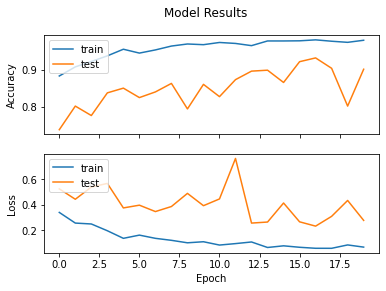

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(b5c3c4_drop_results)

**Analysis of Model**

The epoch with the lowest testing loss has a training acuracy of 92% and a testing accuracy of 76%, with a training loss of 23% and a testing loss of 50%. Testing recall is 83% and testing precision is 94%. This model is performing worse than the last pretrained model with all layers frozen and no dropout layers, so in the next iteration I will freeze all layers and remove one of the dropout layers to see if this helps.

## **Freezing all Layers, just including one dropout layer**

In [ ]:
# Build first model using pretrained VGG 19 as first layer, and then some dense layers on top
pre_drop = keras.Sequential()
pre_drop.add(cnn_vgg)
pre_drop.add(layers.Flatten())
pre_drop.add(layers.Dense(128, activation='relu'))
pre_drop.add(layers.Dropout(0.4))
pre_drop.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
Freeze_Pretrained_Base(cnn_vgg, pre_drop)

vgg19 False
flatten_2 True
dense_4 True
dropout_2 True
dense_5 True
4


In [ ]:
# Setting up early stopping and model checkpoints so that model stops training after testing loss stops improving and so that
# weights from the epoch with the lowest testing loss are saved
# Information on how to set up early stopping from: 
# https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb
early_stop_pre3 = [EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
            ModelCheckpoint(filepath='pre3_best_model.h5', monitor='val_loss',
                           save_best_only=True)]

In [ ]:
pre_drop.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

pre_drop_results = pre_drop.fit_generator(train_generator,
                                         steps_per_epoch=2699//20+1,# number of samples / batch size
                                         epochs=20,
                                        callbacks= early_stop_pre3,
                                         validation_data=test_generator,
                                             validation_steps=394//20+1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
135/135 [==============================] - 42s 302ms/step - loss: 0.3031 - acc: 0.8922 - recall: 0.9605 - precision: 0.9182 - true_positives: 2235.0000 - true_negatives: 173.0000 - false_positives: 199.0000 - false_negatives: 92.0000 - val_loss: 0.5384 - val_acc: 0.7107 - val_recall: 0.6990 - val_precision: 0.8821 - val_true_positives: 202.0000 - val_true_negatives: 78.0000 - val_false_positives: 27.0000 - val_false_negatives: 87.0000
Epoch 2/20
135/135 [==============================] - 40s 296ms/step - loss: 0.2048 - acc: 0.9222 - recall: 0.9755 - precision: 0.9369 - true_positives: 2270.0000 - true_negatives: 219.0000 - false_positives: 153.0000 - false_negatives: 57.0000 - val_loss: 0.5174 - val_acc: 0.7360 - val_recall: 0.7301 - val_precision: 0.8903 - val_true_positives: 211.0000 - val_true_negatives: 79.0000 - val_false_positives: 26.0000 - val_false_negatives: 78.0000
Epoch 3/20
135/135 [==============================] - 40s 297ms/step - loss: 0.1778 - acc: 0.9333 - 

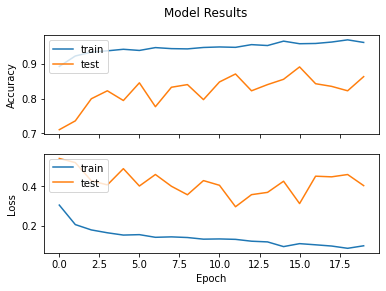

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(pre_drop_results)

**Analysis of Model**

The epoch with the lowest testing loss had a training accuracy of 93% and a testing accuracy of 75%, with a training loss of 17% and a testing loss of 50%. Testing recall is 75% and Testing precision is 89%. In terms of accuracy and loss, this iteration is performing similarly to the last model, and in terms of recall and precision it is performing worse. Next I will try incorporating class weights into pretrained network.

## **Incorporating Class Weights into Pretrained VGG-19**

In [ ]:
# Build first model using pretrained VGG 19 as first layer, and then some dense layers on top
w3_b5c1c2 = keras.Sequential()
w3_b5c1c2.add(cnn_vgg)
w3_b5c1c2.add(layers.Flatten())
w3_b5c1c2.add(layers.Dense(128, activation='relu'))
w3_b5c1c2.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
Freeze_Pretrained_Base(cnn_vgg, w3_b5c1c2)

vgg19 False
flatten_3 True
dense_6 True
dense_7 True
4


In [ ]:
# Setting up early stopping and model checkpoints so that model stops training after testing loss stops improving and so that
# weights from the epoch with the lowest testing loss are saved
# Information on how to set up early stopping from: 
# https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb
early_stop2 = [EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss',
                           save_best_only=True)]

In [ ]:
# Incorporating adjusted class weights; compiling and fitting the model
weights3 = {0: 3, # NO TUMOR
          1:1.} # TUMOR 
# there are 6.255 times as many images of MRIs with tumors than without, but acording to the class weight calculation, I should 
# use a number close to 3.63 for the minority class, in this case the no tumor, or "zero" class.


w3_b5c1c2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

w3_b5c1c2_results = w3_b5c1c2.fit_generator(train_generator,
                                          class_weight = weights3,
                                         steps_per_epoch=2699//20+1,# number of samples / batch size + 1
                                         epochs=20,
                                        callbacks= early_stop2,
                                         validation_data=test_generator,
                                        validation_steps=394//20+1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
135/135 [==============================] - 42s 304ms/step - loss: 0.6769 - acc: 0.8781 - recall: 0.9149 - precision: 0.9420 - true_positives: 2129.0000 - true_negatives: 241.0000 - false_positives: 131.0000 - false_negatives: 198.0000 - val_loss: 0.4782 - val_acc: 0.7970 - val_recall: 0.8651 - val_precision: 0.8591 - val_true_positives: 250.0000 - val_true_negatives: 64.0000 - val_false_positives: 41.0000 - val_false_negatives: 39.0000
Epoch 2/20
135/135 [==============================] - 40s 298ms/step - loss: 0.3083 - acc: 0.9244 - recall: 0.9428 - precision: 0.9687 - true_positives: 2194.0000 - true_negatives: 301.0000 - false_positives: 71.0000 - false_negatives: 133.0000 - val_loss: 0.4577 - val_acc: 0.7792 - val_recall: 0.8131 - val_precision: 0.8769 - val_true_positives: 235.0000 - val_true_negatives: 72.0000 - val_false_positives: 33.0000 - val_false_negatives: 54.0000
Epoch 3/20
135/135 [==============================] - 40s 296ms/step - loss: 0.2565 - acc: 0.9441 -

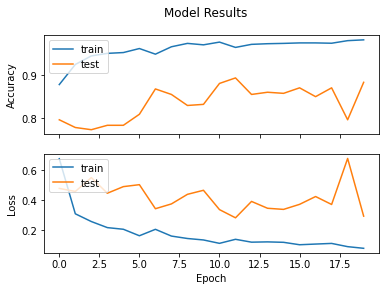

In [ ]:
# Look at how accuracy and loss change across the epochs, for training and testing data
visualize_training_results(w3_b5c1c2_results)

**Analysis of Model**

The epoch with the lowest testing loss has a training accuracy of 98% and a testing accuracy of 91%, with a training loss of 10% and a testing loss of 26%. Testing recall is 89% and testing precision is 98%.

From looking at the training and testing accuracy and loss, it is obvious that this is the most competent model yet. Overfitting has been greatly reduced, testing loss has been reduced considerably, and there is high recall and precision. Now it is time to evaluate the model on the validation hold-out set.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


Val Loss: 0.09629638493061066
Val Accuracy: 0.9766082167625427
Val Recall: 1.0
Val Precision: 0.9736841917037964
Val True Positives: 148.0
Val True Negatives: 19.0
Val False Positives: 4.0
Val False Negatives: 0.0


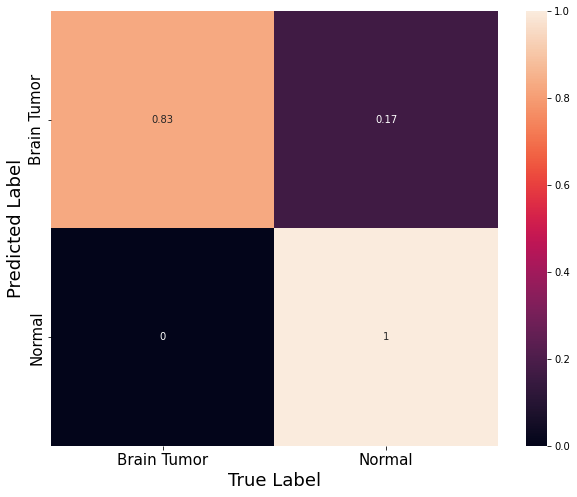

In [ ]:
print_metrics_confusionmatrix('best_model.h5', val_generator, 'Val')